In [21]:
# Handling Missing Data & Outliers in UAV Dataset

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error


In [22]:
# Load Titanic dataset
titanic = sns.load_dataset("titanic")
print(titanic.shape)
titanic.head()


(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


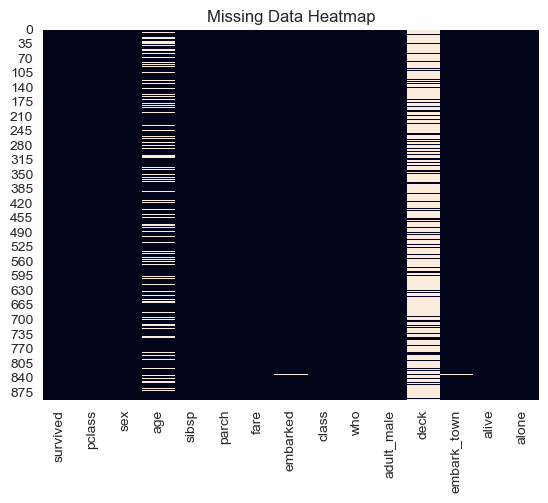

In [23]:
# Missing summary
print(titanic.isna().sum())

# Visual heatmap
sns.heatmap(titanic.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


In [24]:
# Drop rows with any missing age
drop_rows = titanic.dropna(subset=['age'])
print("Before:", titanic.shape, "After:", drop_rows.shape)

# Drop columns with too many NaNs
drop_cols = titanic.drop(columns=['deck'])
print("Dropped 'deck' → Shape:", drop_cols.shape)

# Drop rows with too many NaNs (keep rows with at least 13 non-NaN values)
drop_thresh = titanic.dropna(thresh=14)
print("After threshold deletion:", drop_thresh.shape)

Before: (891, 15) After: (714, 15)
Dropped 'deck' → Shape: (891, 14)
After threshold deletion: (731, 15)


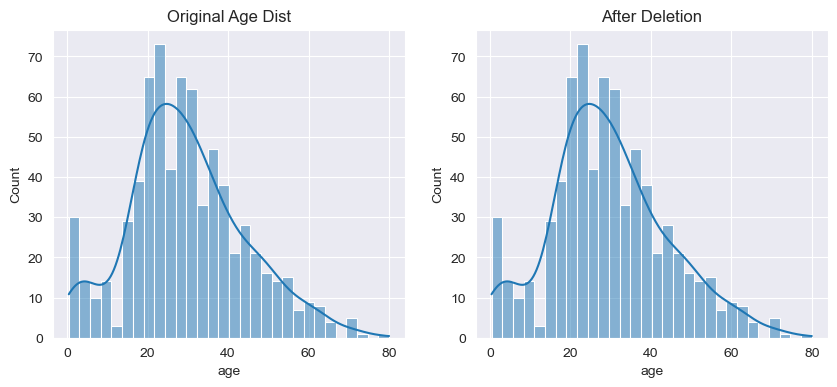

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(titanic['age'], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Original Age Dist")
sns.histplot(drop_rows['age'], bins=30, kde=True, ax=ax[1])
ax[1].set_title("After Deletion")
plt.show()

In [26]:

df_del = titanic.dropna()
print("After Deletion Shape:", df_del.shape)


After Deletion Shape: (182, 15)


(b) Imputation Methods

Instead of deleting, fill in the missing values.

1.Mean Imputation

Replace missing values with the column’s mean.

. Good when data is normally distributed.

. Risk: shrinks variance (underestimates extremes).

2.Median Imputation

Replace missing values with the column’s median.

 . Better for skewed data.

 . More robust to outliers.

3.Interpolation

Estimate missing values based on trends in neighboring data (linear, time-based).

. Best when data is time-series (like our UAV alt_gps_m).

. Maintains continuity in signals.

In [27]:
imp_mean = SimpleImputer(strategy="mean")
titanic['age_mean'] = imp_mean.fit_transform(titanic[['age']])

imp_median = SimpleImputer(strategy="median")
titanic['age_median'] = imp_median.fit_transform(titanic[['age']])



In [28]:
imp_mode = SimpleImputer(strategy="most_frequent")
titanic['age_mode'] = imp_mode.fit_transform(titanic[['age']])



In [29]:
titanic['age_ffill'] = titanic['age'].fillna(method='ffill')


C:\Users\Roktim\AppData\Local\Temp\ipykernel_12644\1746434384.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic['age_ffill'] = titanic['age'].fillna(method='ffill')


forward fill: *Take* the last known (non-missing) value and use it to fill the next missing entry.

Passenger	Age

1	22

2	NaN

3	24

4	NaN

5	NaN

6	30


Passenger	Age (ffill)

1	22

2	22 ← filled from Passenger 1

3	24

4	24 ← filled from Passenger 3

5	24 ← still filled from Passenger 3

6	30

In [30]:
titanic['age_bfill'] = titanic['age'].fillna(method='bfill')

C:\Users\Roktim\AppData\Local\Temp\ipykernel_12644\4118933833.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic['age_bfill'] = titanic['age'].fillna(method='bfill')


KNNImputer(n_neighbors=x) sets up a k-nearest neighbors imputer that will, for each missing value, look at the x most similar rows (neighbors) to estimate it.

In [31]:
knn = KNNImputer(n_neighbors=5)
titanic['age_knn'] = knn.fit_transform(titanic[['age','fare']])[:,0]

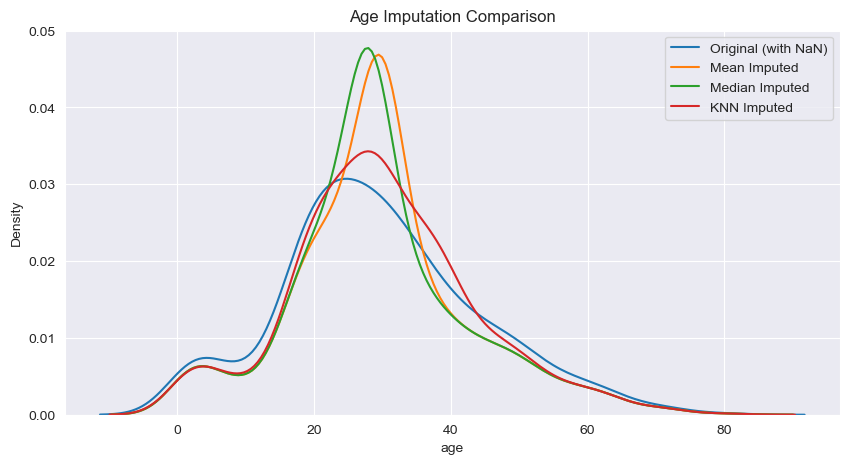

In [32]:
plt.figure(figsize=(10,5))
sns.kdeplot(titanic['age'], label='Original (with NaN)')
sns.kdeplot(titanic['age_mean'], label='Mean Imputed')
sns.kdeplot(titanic['age_median'], label='Median Imputed')
sns.kdeplot(titanic['age_knn'], label='KNN Imputed')
plt.legend(); plt.title("Age Imputation Comparison"); plt.show()

Mean imputation pulls values toward the center, shrinking variability and making the distribution more "peaked."

Median imputation is more robust to skew and outliers, so the curve is often closer to the original.

KNN imputation can preserve natural shape better, since it uses relationships with other features, not just one summary statistic.

# 🔹 Interpolation

**Definition**  
Interpolation = estimating missing values by assuming that data follows a **continuous trend** between known points.  

**Idea**  
If values are *smoothly varying*, then missing values can be filled by using values **before and after the gap**.  

**Applications**  
- Widely used in **time series**, **sensor data**, and **numeric sequences**.  

---

## 🔸 Types of Interpolation

### 1. Linear Interpolation
- Assumes a straight line between two known points.  
- Formula:

$
x(t) = x_1 + \frac{(x_2 - x_1)}{(t_2 - t_1)} \cdot (t - t_1)
$

Where:  
- $(t_1, x_1)$ and $(t_2, x_2)$ are known points  
- \(t\) is a point between \($t_1$\) and \($t_2$\)  

---

### 2. Polynomial Interpolation
- Breaks the data into small intervals and fits a low-degree polynomial (often cubic) in each interval.
- Fit a polynomial through known data points and use it to estimate missing ones.  
- **Risk:** High-degree polynomials may **overfit** and create unrealistic oscillations.  

---

### 3. Spline Interpolation
- Piecewise polynomial fits (commonly **cubic splines**).  
- Provides a **smooth curve** and avoids oscillations found in high-degree polynomials.  

---

### 4. Time-based Interpolation
- If the index is **time**, interpolation can consider **actual time gaps** instead of row order.  
- Very useful in **sensor logs, IoT data, and financial time series**.  


In [33]:
# Apply linear interpolation on 'age'
titanic['age_linear'] = titanic['age'].interpolate(method='linear')

# Check before vs after for some rows with missing values
print(titanic.loc[titanic['age'].isna(), ['age','age_linear']].head(10))

    age  age_linear
5   NaN   44.500000
17  NaN   16.500000
19  NaN   33.000000
26  NaN   28.500000
28  NaN   26.000000
29  NaN   33.000000
31  NaN   48.666667
32  NaN   57.333333
36  NaN   31.500000
42  NaN   15.000000


In [34]:
# Polynomial interpolation (order 2 = quadratic)
titanic['age_poly'] = titanic['age'].interpolate(method='polynomial', order=2)

# Spline interpolation (cubic smoothing)

titanic['age_spline'] = titanic['age'].interpolate(method='spline', order=3)

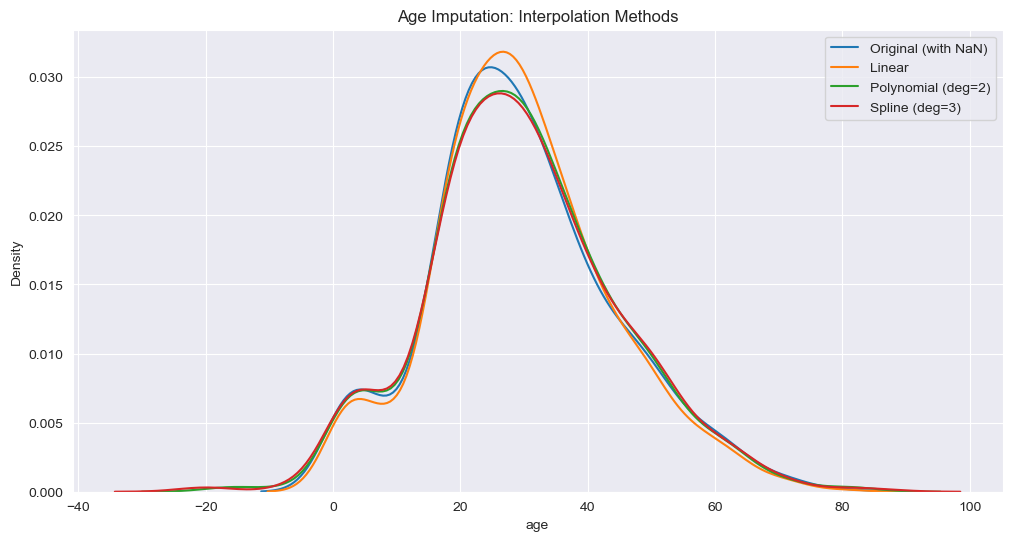

In [35]:
plt.figure(figsize=(12,6))
sns.kdeplot(titanic['age'], label='Original (with NaN)')
sns.kdeplot(titanic['age_linear'], label='Linear')
sns.kdeplot(titanic['age_poly'], label='Polynomial (deg=2)')
sns.kdeplot(titanic['age_spline'], label='Spline (deg=3)')
plt.legend()
plt.title("Age Imputation: Interpolation Methods")
plt.show()

**Outlier detection**

Z-Score Method

What it is: Standardize values and check how many standard deviations away from the mean.

Formula:

𝑍=(𝑥
−
𝜇
)/
𝜎


Rule: If |Z| > 3, treat as outlier.


Works well if data is approximately normal (bell-shaped).

Sensitive to skewed or non-normal distributions.

Mean and std can themselves be distorted by extreme outliers.

Z-score outliers in fare: 20


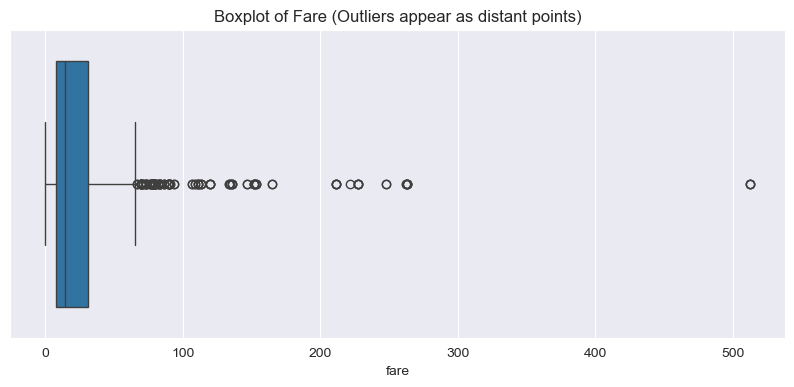

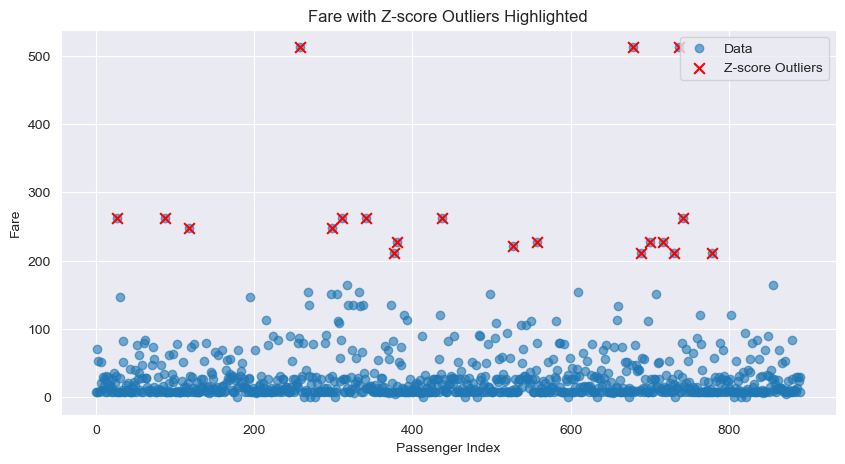

In [36]:
from scipy.stats import zscore

titanic['fare_z'] = zscore(titanic['fare'].fillna(0))
outliers_z = titanic[np.abs(titanic['fare_z']) > 3]
print("Z-score outliers in fare:", outliers_z.shape[0])


# --- Visualization 1: Boxplot highlighting outliers ---
plt.figure(figsize=(10,4))
sns.boxplot(x=titanic['fare'])
plt.title("Boxplot of Fare (Outliers appear as distant points)")
plt.show()

# --- Visualization 2: Scatterplot with outliers highlighted ---
plt.figure(figsize=(10,5))
plt.scatter(range(len(titanic)), titanic['fare'], label="Data", alpha=0.6)
plt.scatter(outliers_z.index, outliers_z['fare'], color='red', label="Z-score Outliers", marker='x', s=60)
plt.xlabel("Passenger Index")
plt.ylabel("Fare")
plt.title("Fare with Z-score Outliers Highlighted")
plt.legend()
plt.show()


# 🔹 Modified Z-Score (Robust Outlier Detection)

**Why not plain Z-score?**  
- Z-score uses the **mean** and **standard deviation**.  
- Both are sensitive to **outliers** and **skewed data**.  
- A few extreme values can distort them.  

**Solution: Modified Z-Score**  
- Uses **Median** and **Median Absolute Deviation (MAD)** instead.  
- Much more **robust** against outliers.  

---

## 📌 Formula

$
M_z = \frac{0.6745 \cdot (x_i - \text{median}(x))}{MAD}
$

where  

$
MAD = \text{median}(|x_i - \text{median}(x)|)
$

- $x_i$ = data point  
- $M_z$ = modified z-score  
- Threshold: \(|M_z| > 3.5\) ⇒ Outlier  

---

## Key Points
- More reliable for **skewed** or **heavy-tailed** distributions.  
- Widely used in **finance, sensor data, and real-world noisy datasets**.  
- Recommended when mean/std are unstable.  

---

##  Example (Titanic `fare`)
If we compute Modified Z-Scores for the `fare` column:  
- Most passenger fares are low/medium.  
- A few very high fares (1st class luxury tickets) will be flagged as outliers.  


Modified Z outliers (fare): 160


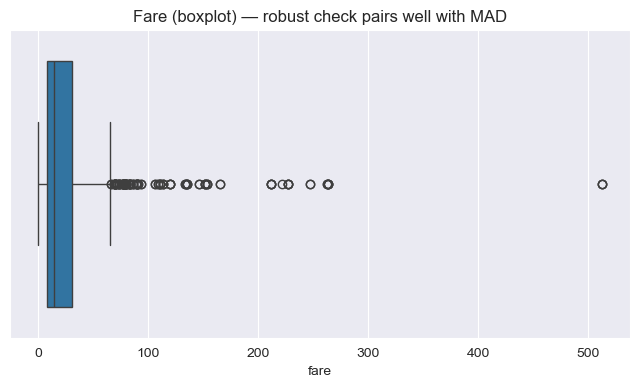

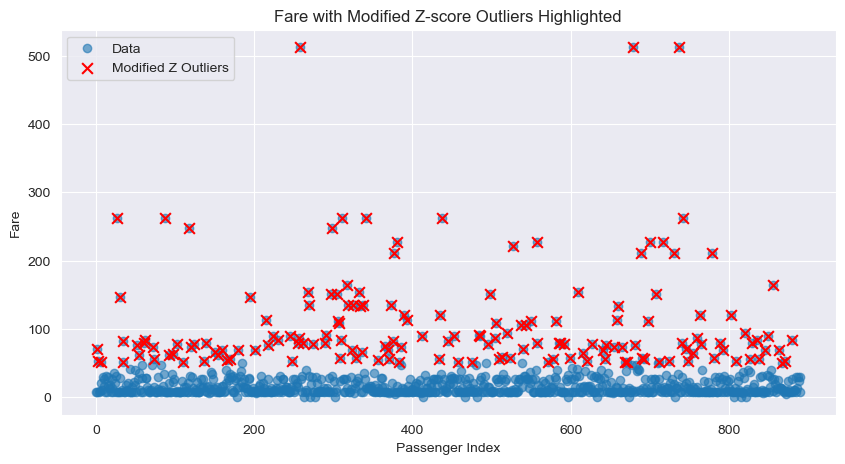

In [37]:
# We'll use these numeric columns, dropping rows with all-NaN across them
num_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch']
X = titanic[num_cols].copy()

# --- Modified Z-score function ---
def modified_zscore(s: pd.Series):
    med = s.median()
    mad = (s - med).abs().median()
    return 0.6745 * (s - med) / mad

# Compute Modified Z-scores for 'fare'
mz = modified_zscore(X['fare'].dropna())
out_mz = mz.abs() > 3.5
print("Modified Z outliers (fare):", out_mz.sum())

# --- Visualization 1: Boxplot ---
plt.figure(figsize=(8,4))
sns.boxplot(x=X['fare'], orient='h')
plt.title("Fare (boxplot) — robust check pairs well with MAD")
plt.show()

# --- Visualization 2: Scatterplot with outliers highlighted ---
plt.figure(figsize=(10,5))
plt.scatter(range(len(X['fare'].dropna())), X['fare'].dropna(),
            label="Data", alpha=0.6)
plt.scatter(np.where(out_mz)[0], X['fare'].dropna()[out_mz],
            color='red', marker='x', s=60, label="Modified Z Outliers")
plt.xlabel("Passenger Index")
plt.ylabel("Fare")
plt.title("Fare with Modified Z-score Outliers Highlighted")
plt.legend()
plt.show()

**IQR** Method

What it is: Based on percentiles.

Formula:

IQR=Q3−Q1

Outlier rule:

Lower bound =

Q1 − 1.5× IQR

Upper bound =

Q3 + 1.5× IQR

Anything outside this range = outlier.


Why useful: Works for non-normal data distributions.



In [38]:
Q1 = titanic['fare'].quantile(0.25)
Q3 = titanic['fare'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

outliers_iqr = titanic[(titanic['fare'] < lower) | (titanic['fare'] > upper)]
print("IQR outliers in fare:", outliers_iqr.shape[0])

IQR outliers in fare: 116


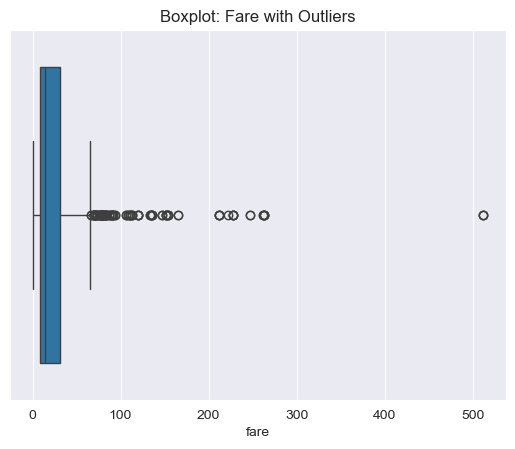

In [39]:
sns.boxplot(x=titanic['fare'])
plt.title("Boxplot: Fare with Outliers")
plt.show()

Missing Data

If left untreated, ML models like Linear Regression or Decision Trees may fail (NaN not supported).

Proper imputation ensures models train on complete data.

Choice of imputation (mean/median/interpolation) affects bias & accuracy.



Outliers

Outliers distort models that rely on mean & variance (Linear Regression, KNN).

Example: One very high speed_kmh can make regression coefficients unstable.

Removing/transforming outliers → more stable & generalizable models.

In [40]:
# Prepare data
df_model = titanic[['fare','age','pclass']].dropna()

X = df_model[['age','pclass']]
y = df_model['fare']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("MSE (with outliers):", mean_squared_error(y_test, y_pred))

# Remove IQR outliers
df_no_out = df_model[(df_model['fare'] >= lower) & (df_model['fare'] <= upper)]
X_no, y_no = df_no_out[['age','pclass']], df_no_out['fare']
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_no, y_no, test_size=0.2, random_state=42)

lr2 = LinearRegression().fit(Xn_train, yn_train)
yn_pred = lr2.predict(Xn_test)
print("MSE (without outliers):", mean_squared_error(yn_test, yn_pred))

MSE (with outliers): 3364.922912856981
MSE (without outliers): 82.19718736439646
